# PhageHostPredict - HDC (Klebsiella)

A Phage-Host interaction predictor framework based on Hyperdimensional Computing with receptors and receptor-binding proteins at its core. This particular PhageHostPredict is for *Klebsiella pneumoniae* related phages.

This notebook follows after having ran the PhageHostPredict_processing steps implemented in the accompanying Python script.

The predictive framework works as follows:

1. [Transform the locus into an embedding using Word2Vec](#locusembed)
2. [Transform the RBP sequence into an embedding](#rbpembed) using UniRep, ProtTransBert, SeqVec, ...
3. Constructing a dataframe for training models
4. [Exploring the interactions space](#interactions) for insight and further improvement
5. [Concatenate and train an RF model](#models) via cross-validation

## 0 - Libraries and directories

In [2]:
push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing
using DataFrames
using ProgressMeter
using CSV
using JSON
using FASTX
using BioAlignments
using Random
using Plots
using StatsBase
using MultivariateStats
using Statistics
using MLJ
using DelimitedFiles
using BioAlignments
using ProgressMeter
#using Pluto

general_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data" # general directory
results_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models"
data_suffix = "Valencia" # choose a suffix for the created data files

"Valencia"

## 1 - Functions

In [3]:
function file_to_array(file)
    """
    Function that reads a FASTA file and puts its sequences in an array.
    """
    sequences = []
    reader = FASTA.Reader(open(file, "r"))
    for record in reader
        seq = FASTA.sequence(record)
        push!(sequences, seq)
    end
    return sequences
end

file_to_array (generic function with 1 method)

In [4]:
function mean_reciprocal_rank(queries)
    """
    This function computes the mean reciprocal rank for a given array of
    queries. It deals with relevant vs. non-relevant queries that are
    binary. E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries]
    return mean(reciprocal_ranks)
end

mean_reciprocal_rank (generic function with 1 method)

## 2 - Computing embeddings & signatures

In this section, we define hyperdimensional vectors for the amino-acid alphabet and use these hyperdimensional vectors to construct *hyperdimensional embeddings* for our loci proteins and RBPs. For the loci proteins, this is a multi-instance setting: multiple proteins will be embedded into hyperdimensional space and then those vectors are aggregated to form one final vector for each locus.

In [17]:
# load data and set names
RBPbase = DataFrame(CSV.File(general_dir*"/RBPbase"*data_suffix*".csv"))
LociBase = JSON.parsefile(general_dir*"/Locibase"*data_suffix*".json")
IM = DataFrame(CSV.File(general_dir*"/interactions_mono"*data_suffix*".csv"))
interaction_matrix = Matrix(IM[1:end, 2:end])
loci_names = IM.accession
serotypes = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"))
rbp_names = names(IM)[2:end];

In [6]:
# define protein alphabet
alphabet = "GAVLIFPSTYCMKRHWDENQX"
basis = Dict(c=>BipolarHDV() for c in alphabet);

In [7]:
# compute loci embeddings w/ proteins (multi-instance)
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 3) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [8]:
# compute rbp embeddings
rbp_embeddings = Array{BipolarHDV}(undef, length(RBPbase.ProteinSeq))
for (i, sequence) in enumerate(RBPbase.ProteinSeq)
    rbp_embeddings[i] = sequence_embedding(string(sequence), basis, 3)
end

In [55]:
# compute the rbp-receptor signatures (bind operation)
signatures_pos = Dict()
signatures_neg = Dict()
for (i, loci_embedding) in enumerate(loci_embeddings)
    for (j, rbp_embedding) in enumerate(rbp_embeddings)
        if isequal(interaction_matrix[i,j], 1)
            signatures_pos[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        elseif isequal(interaction_matrix[i,j], 0)
            signatures_neg[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        end
    end
end
#signatures_pos = convert(Array{BipolarHDV}, signatures_pos)
#signatures_neg = convert(Array{BipolarHDV}, signatures_neg)
println("pos: ", length(signatures_pos), " neg: ", length(signatures_neg))

pos: 29 neg: 1149


## 3 - Exploration

In this section, we explore the data and the computed embeddings.

#### Unique serotypes

Most serotypes are unique, and thus only occur the number of times we have RBPs in the dataset (currently 19, 6/5/22).

In [ ]:
serotypes = serotypes[:,1]
B = [(i, count(==(i), serotypes)) for i in unique(serotypes)]

#### PCA of the RBP embeddings

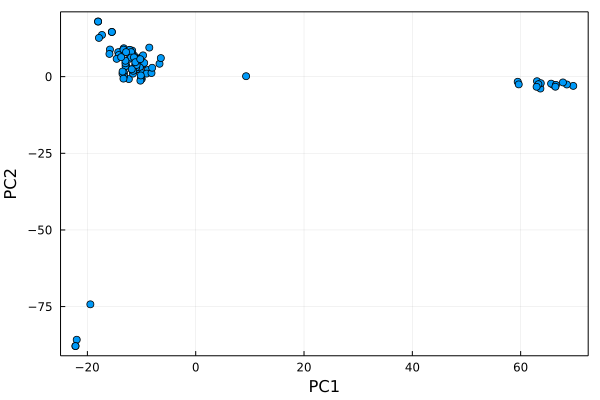

In [127]:
# flip the embeddings for PCA
rbp_embeddings_flipped = zeros(Int64, 10000, length(RBPbase.ProteinSeq))
for i in range(1, length=length(RBPbase.ProteinSeq))
    rbp_embeddings_flipped[:,i] = rbp_embeddings[i]
end

# compute the PCA
pca = fit(PCA, rbp_embeddings_flipped, pratio=1, maxoutdim=4)
proj = projection(pca) # each column is a principal component
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
rbp_transformed = MultivariateStats.transform(pca, rbp_embeddings_flipped)
h = plot(rbp_transformed[1,:], rbp_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

#### PCA of loci embeddings

In [ ]:
# flip the embeddings for PCA
loci_embeddings_flipped = zeros(Int64, 10000, length(LociBase))
for i in range(1, length=length(LociBase))
    loci_embeddings_flipped[:,i] = loci_embeddings[i]
end

# compute the PCA
pca = fit(PCA, loci_embeddings_flipped, pratio=1, maxoutdim=4)
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
loci_transformed = MultivariateStats.transform(pca, loci_embeddings_flipped)
h = plot(loci_transformed[1,:], loci_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

#### PCA of the signatures colored by RBP

In [85]:
# flip the signatures for PCA
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = []
i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    push!(labels, rbp_names[key[2]])
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    push!(labels, rbp_names[key[2]])
    i = i+1
end

# compute the PCA
pca = fit(PCA, signatures_flipped, pratio=1, maxoutdim=4);

# visualize
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter, legend = :outertopright)
for label in unique(labels)
    idx = [i for (i, lab) in enumerate(labels) if lab == label]
    plot!([signatures_transformed[1, idx]], [signatures_transformed[2, idx]], seriestype=:scatter, label=label)  
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

In [126]:
savefig(h, results_dir*"/HDC_PCA_signatures_RBPcolor.png")

#### Exploring similarities between the embeddings

Idea: compute the cosine similarities between all HDC embeddings and compare that with alignment similarity scores.

In [141]:
# read RBP alignment matrix
rbp_sim = readdlm(general_dir*"/RBPbaseValencia.fasta_score_matrix.txt", '\t');

# compute cosine similarities for RBP embeddings
rbp_embeddings_sim = zeros(Float64, length(rbp_embeddings), length(rbp_embeddings))
for i in range(1, length=length(rbp_embeddings))
    for j in range(1, length=length(rbp_embeddings))
        rbp_embeddings_sim[i,j] = cos_sim(rbp_embeddings[i], rbp_embeddings[j])
    end
end

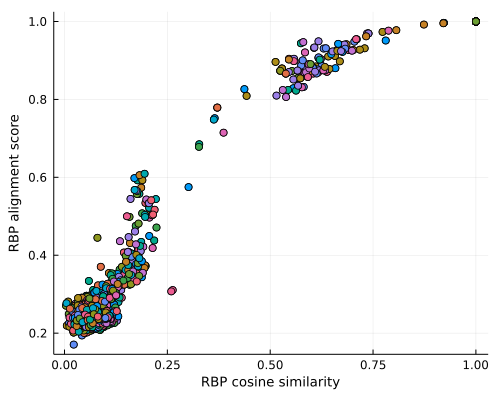

In [152]:
# Make RBP scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(rbp_embeddings))
    for j in range(1, length=length(rbp_embeddings))
        plot!([rbp_embeddings_sim[i, j]], [rbp_sim[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="RBP cosine similarity", xguidefontsize=9, ylabel="RBP alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [163]:
# compute RBP correlation
flat_rbp_sim = vcat(rbp_sim...)
flat_rbp_embeddings_sim = vcat(rbp_embeddings_sim...)
cor(flat_rbp_sim, flat_rbp_embeddings_sim)

0.9578251321909989

In [207]:
# compute loci embeddings w/ proteins (multi-instance)
basis = Dict(c=>GradedBipolarHDV() for c in alphabet);
loci_embeddings = Array{GradedBipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 3) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [208]:
# read loci alignment matrix
loci_sim = readdlm(general_dir*"/kaptive_results_all_loci.fasta_score_matrix.txt", '\t');

# compute cosine similarities for loci embeddings
loci_embeddings_sim = zeros(Float64, length(loci_embeddings), length(loci_embeddings))
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        loci_embeddings_sim[i,j] = cos_sim(loci_embeddings[i], loci_embeddings[j])
    end
end

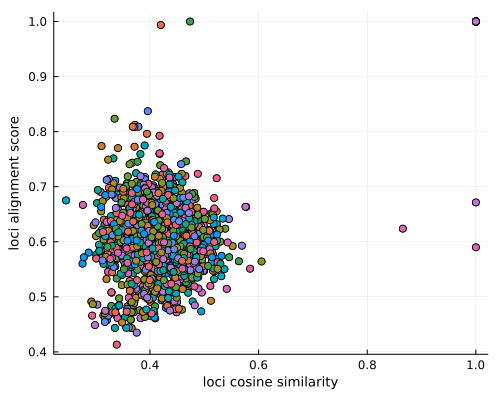

In [209]:
# Make loci scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        plot!([loci_embeddings_sim[i, j]], [loci_sim[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="loci cosine similarity", xguidefontsize=9, ylabel="loci alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [210]:
# compute loci correlation
flat_loci_sim = vcat(loci_sim...)
flat_loci_embeddings_sim = vcat(loci_embeddings_sim...)
cor(flat_loci_sim, flat_loci_embeddings_sim)

0.5250942434977383

We see that the correlation between the RBP embeddings scores and alignment scores is very good, which indicates that the (evolutionary) information of the RBPs is well captured in the embeddings (for as far as we can see alignment as a proxy for this information). However, for the loci embeddings, we don't see quite a good correlation between the alignment scores and embedding similarities. This could be due to several reasons:

- alignment is a bad measure for similarity for these long strethes of DNA (or the particular type of alignment).
- the computed embeddings don't contain the information we want.
- disconnect between alignment at the DNA level and embeddings at the protein level.
- multi-instance setting is not well defined/computed.

#### Further analysis of loci similarities

We will try a second approach: compute the similarities between all loci proteins separately, both with alignment and embeddings, and then compare both. If they turn out appropriately, then the problem is either the loci alignment itself or the multi-instance combo.

In [212]:
all_loci_proteins = []
for (key, value) in LociBase
    for protein in value
        push!(all_loci_proteins, protein)
    end
end

In [215]:
score_matrix = zeros(length(all_loci_proteins), length(all_loci_proteins))
score_model = AffineGapScoreModel(BLOSUM62, gap_open=-5, gap_extend=-1)
p = Progress(Int64(round((length(all_loci_proteins)^2), digits=0)))
# do pairwise alignments
for i in 1:length(all_loci_proteins)
    for j in 1:length(all_loci_proteins)
        res = pairalign(LocalAlignment(), all_loci_proteins[i], all_loci_proteins[j], score_model);
        aln = alignment(res)
        score_matrix[i,j] = count_matches(aln) / count_aligned(aln)
        next!(p)
    end
end

Progress:  44%|██████████████████▎                      |  ETA: 0:20:35:08

LoadError: InterruptException:

In [ ]:
# compute loci embeddings for all proteins 
basis = Dict(c=>BipolarHDV() for c in alphabet);
loci_embeddings = Array{BipolarHDV}(undef, length(all_loci_proteins))
for protein in all_loci_proteins
    protein_hdv = sequence_embedding(string(protein), basis, 3)
    loci_embeddings[i] = protein_hdv
end

# compute cosine similarities for all loci proteins
loci_embeddings_sim = zeros(Float64, length(loci_embeddings), length(loci_embeddings))
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        loci_embeddings_sim[i,j] = cos_sim(loci_embeddings[i], loci_embeddings[j])
    end
end

In [ ]:
# Make loci scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        plot!([loci_embeddings_sim[i, j]], [score_matrix[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="loci proteins cosine similarity", xguidefontsize=9, ylabel="loci alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

## 4 - Simple evaluation

In [ ]:
# shuffle and split in train-test
sign_pos = shuffle(signatures_pos)
sign_neg = shuffle(signatures_neg)
cutoff_pos = Int(round(length(signatures_pos)*0.75))
cutoff_neg = Int(round(length(signatures_neg)*0.75))
training_pos = sign_pos[1:cutoff_pos]
training_neg = sign_neg[1:cutoff_neg]
testing_pos = sign_pos[cutoff_pos+1:end]
testing_neg = sign_neg[cutoff_neg+1:end]

# train classes (aggregate)
training_pos_agg = HyperdimensionalComputing.aggregate(training_pos)
training_neg_agg = HyperdimensionalComputing.aggregate(training_neg)

# compute distances (Cosine sim for RealHDVs)
dist_pos_test = [cos_sim(training_pos_agg, x) for x in testing_pos]
dist_neg_test = [cos_sim(training_pos_agg, x) for x in testing_neg]

# make plots
hist = histogram(dist_pos_test, label="positive test", alpha=0.7, legend=:topleft, nbins=40)
histogram!(dist_neg_test, label="negative test", alpha=0.7, nbins=30)
savefig(hist, results_dir*"/HDC_histogram.png")

rank_plot = plot(sort!(dist_pos_test), label="positive test", alpha=0.7, legend=:bottomright, xlabel="rank", ylabel="Cosine sim")
plot!(sort!(dist_neg_test), label="negative test", alpha=0.7)
savefig(rank_plot, results_dir*"/HDC_rank_plot.png")


## 5 - Cross-validation

In [ ]:
"""
Here, we perform a 10-fold CV over the loci, just like we do to evaluate the
binary classifiers in Python.
"""
loci_known = [x for x in range(1, length=length(LociBase)) 
                if (any(isequal.(interaction_matrix[x,:], 0))) 
                    || (any(isequal.(interaction_matrix[x,:], 1)))]

# shuffle loci
loci_shuffle = shuffle(loci_known)

# divide into 10 groups
group_size = div(length(loci_shuffle), 10) + 1
get_groups(x, n) = [x[i:min(i+n-1,length(x))] for i in 1:n:length(x)]
loci_groups = get_groups(loci_shuffle, group_size)

# loop over groups
loci_nr = []; rbp_nr = []; scores = []; scores_pos = []; labels = []
for group in loci_groups
    # compute signatures for training and testing parts (group = test)
    signatures_train_pos = []
    signatures_train_neg = []
    signatures_test = []
    for (i, loci_embedding) in enumerate(loci_embeddings)
        for (j, rbp_embedding) in enumerate(rbp_embeddings)
            # training pos interaction
            if isequal(interaction_matrix[i,j], 1) && i ∉ group
                push!(signatures_train_pos, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
            # training neg interaction
            elseif isequal(interaction_matrix[i,j], 0) && i ∉ group
                push!(signatures_train_neg, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
            # test interaction
            elseif isequal(interaction_matrix[i,j], 1) && i in group
                push!(signatures_test, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
                push!(loci_nr, i-1) # -1 to cope with indexing python
                push!(rbp_nr, j-1)
                push!(labels, interaction_matrix[i,j])
            elseif isequal(interaction_matrix[i,j], 0) && i in group
                push!(signatures_test, HyperdimensionalComputing.bind([loci_embedding, rbp_embedding]))
                push!(loci_nr, i-1)
                push!(rbp_nr, j-1)
                push!(labels, interaction_matrix[i,j])
            end
        end
    end

    # convert signatures
    signatures_train_pos = convert(Array{BipolarHDV}, signatures_train_pos)
    signatures_train_neg = convert(Array{BipolarHDV}, signatures_train_neg)
    signatures_test = convert(Array{BipolarHDV}, signatures_test)
    println("train size:", length(signatures_train_pos)+length(signatures_train_neg))
    println("test size:", length(signatures_test))
    
    # aggregate training signatures
    signatures_pos_agg = HyperdimensionalComputing.aggregate(signatures_train_pos)
    signatures_neg_agg = HyperdimensionalComputing.aggregate(signatures_train_neg)

    # compute distance/similarity to test signatures
    for test in signatures_test
        score_pos_agg = cos_sim(signatures_pos_agg, test)
        score_neg_agg = cos_sim(signatures_neg_agg, test)
        push!(scores, score_pos_agg/score_neg_agg) # > 1 then pos, < 1 then neg
        push!(scores_pos, score_pos_agg)
    end
end

# results pos vs. neg
results = DataFrame(locus=loci_nr, rbps=rbp_nr, scores=scores, label=labels)
CSV.write(results_dir*"/results_HDC_grouped10CV_"*data_suffix*".csv", results)

# results pos only
results = DataFrame(locus=loci_nr, rbps=rbp_nr, scores=scores_pos, label=labels)
CSV.write(results_dir*"/results_HDCpos_grouped10CV_"*data_suffix*".csv", results)

# examine scores
histogram(scores, xlabel="score", ylabel="count")
sum(scores .< 1)/length(scores)